# East Coast Fall 2020 Fall Regional Datathon

#### Team members: 
Name, email

* Hojin Lee, hl3328@columbia.edu
* Tae Yoon Lim, tl2968@columbia.edu
* Tony Tohme, tohme@mit.edu
* Haoyang Wang, hw2758@columbia.edu

In [101]:
df_movies = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/movies.csv')


In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
movie_industry = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_industry.csv', encoding='latin-1')
oscar_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/the_oscar_award.csv')
genome_scores_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/genome-scores.csv')
genome_tag_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/genome-tags.csv')
links_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/links.csv')
movies_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/movies.csv')
ratings_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/ratings.csv')
tags_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/tags.csv')



In [18]:
movies_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/movies.csv')
movies_df.genres = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [5]:
movie_industry = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_industry.csv', encoding='latin-1')
oscar_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/the_oscar_award.csv')


In [482]:
movie_industry.head()
print(len(movie_industry))

6820


In [459]:
oscar_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [89]:
oscar_unique = oscar_df[oscar_df['winner']==True][['ceremony','film','winner']].drop_duplicates()
oscar_unique['nominated'] = 1 
print(len(oscar_unique))
merged = movie_industry.merge(oscar_unique, left_on='name', right_on ='film', how='left')
merged.drop(['ceremony'], axis=1, inplace=True)
merged['nominated'] = merged['nominated'].fillna(0)
merged = merged[merged['country']=='USA']
print(len(merged))

1376
4877


In [90]:
merged.head()

,index,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,film,winner
0,0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986,NaN,0.0
1,1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986,NaN,0.0
2,2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986,Top Gun,1.0
3,3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986,Aliens,1.0
4,4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986,NaN,0.0


In [91]:
X = merged.loc[:, merged.columns != 'winner'] 
y = merged['winner']

#X.drop(['country', 'director', 'star','name', 'released', 'writer', 'year','film','rating','votes','score'], axis=1, inplace=True)
X = X[['company','genre', 'rating','votes','score']]
avg_pl_conversion = merged[merged['budget']!=0]['gross'].mean() / merged[merged['budget']!=0]['budget'].mean()
#X.loc[X.budget == 0, 'budget'] = X[X.budget == 0]['gross']/ avg_pl_conversion
#X.drop(['score','budget', 'gross'], axis=1, inplace=True)

X.head()

,company,genre,rating,votes,score
0,Columbia Pictures Corporation,Adventure,R,299174,8.1
1,Paramount Pictures,Comedy,PG-13,264740,7.8
2,Paramount Pictures,Action,PG,236909,6.9
3,Twentieth Century Fox Film Corporation,Action,R,540152,8.4
4,Walt Disney Pictures,Adventure,PG,36636,6.9


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import sklearn
from imblearn.pipeline import Pipeline


In [486]:
merged.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,film,nominated
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986,Stand by Me,1.0
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986,NaN,0.0
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986,Top Gun,1.0
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986,Aliens,1.0
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986,NaN,0.0


In [442]:
ratings_df['year'] = ratings_df['timestamp'].map(lambda x: datetime.fromtimestamp(x).year)
ratings_df['month'] = ratings_df['timestamp'].map(lambda x: datetime.fromtimestamp(x).month)

In [454]:
oscar_winning_rating_df = ratings_df[ratings_df['movieId'].isin(movielens_oscar_data['movieId'].values)]

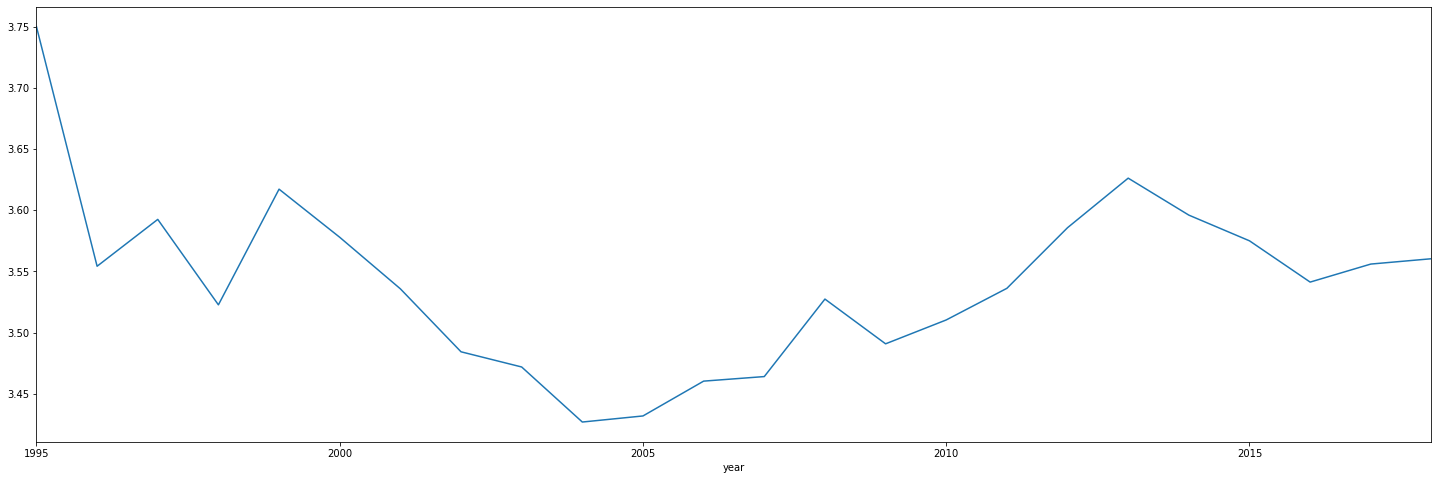

In [453]:
ratings_df.groupby('year').mean().rating.plot()


In [428]:
oscar_winning_film = oscar_df[(oscar_df.winner==True)].film.unique().tolist()
len(oscar_winning_film)

1274

In [113]:
#Oscar winning movie simliarities 

movies_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/movies.csv')

df = movies_df
df['year'] = df['title'].map(lambda x: str(x).rstrip()[-5:-1])
df['title'] = df['title'].map(lambda x: str(x)[:-7])
df = df[df.year.apply(lambda x: x.isnumeric())]

oscar_winning_film = oscar_df[oscar_df.winner==True].film.unique().tolist()
print('The number of movies that won oscar: ', len(oscar_winning_film))
print('The number of movies that were in movie lens data was: ', len(df[df['title'].isin(oscar_winning_film)]))

movielens_oscar_data = df[df['title'].isin(oscar_winning_film)]
movielens_oscar_data.head()

The number of movies that won oscar:  1274
The number of movies that were in movie lens data was:  947


,movieId,title,genres,year
6,7,Sabrina,Comedy|Romance,1995
16,17,Sense and Sensibility,Drama|Romance,1995
24,25,Leaving Las Vegas,Drama|Romance,1995
33,34,Babe,Children|Drama,1995
35,36,Dead Man Walking,Crime|Drama,1995


In [116]:
movies_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/movies.csv')
genome_tag_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/genome-tags.csv')
genome_scores_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/genome-scores.csv')

genome_scores_df['rank'] = genome_scores_df.groupby('movieId')['relevance'].rank(ascending=False, method='first')
genome_scores_df.sort_values(by='rank', ascending=True)

genome_scores_df_top50 = genome_scores_df[genome_scores_df['rank'] < 50]

genome_scores_df_top50 = genome_scores_df_top50.merge(genome_tag_df)
genome_scores_df_top50 = genome_scores_df_top50.merge(movies_df)

df = genome_scores_df_top50.groupby('movieId')['tag'].apply(list).reset_index(name='tags')
df = df.merge(movies_df)
df = df[df['movieId'].isin(movielens_oscar_data['movieId'].values)]
df['year'] = df['title'].map(lambda x: str(x)[-5:-1])
df['title'] = df['title'].map(lambda x: str(x)[:-7])
df.genres = df.genres.str.split('|')
df_tags = df.join(df.tags.str.get_dummies(","))
df_tags

,movieId,tags,title,genres,year,"""so bad it's funny""","""writer's life""","""writer's life""]",'007 (series)','007',...,['good',['great ending',['great movie',['great',['heartwarming',['imdb top 250',['interesting',['light',['mentor',['original'
6,7,"[classic, cute, dialogue, family, feel-good, f...",Sabrina,"[Comedy, Romance]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,17,"[classic, good, great, heartwarming, light, or...",Sense and Sensibility,"[Drama, Romance]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,25,"[imdb top 250, original, death, good soundtrac...",Leaving Las Vegas,"[Drama, Romance]",1995,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
33,34,"[adventure, animated, animation, children, cle...",Babe,"[Children, Drama]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,36,"[imdb top 250, mentor, original, based on a bo...",Dead Man Walking,"[Crime, Drama]",1995,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13106,177765,"[adventure, animation, childhood, children, cl...",Coco,"[Adventure, Animation, Children]",2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13110,178061,"[clever, dialogue, feel-good, good, great endi...","I, Tonya",[Drama],2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13129,179817,"[dialogue, good, great, great ending, great mo...",Darkest Hour,"[Drama, War]",2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13133,180031,"[dialogue, family, light, original, storytelli...",The Shape of Water,"[Adventure, Drama, Fantasy]",2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
cos_sim = cosine_similarity(df_tags.iloc[:,5:])
cos_sim


NameError: name 'cosine_similarity' is not defined

In [ ]:
from sklearn.manifold import TSNE
#df_gescores_table is the df file from the csv
X_for_graph = df_tags.iloc[:,5:]
X_for_graph = TSNE(n_components = 2, random_state = 42).fit_transform(X_for_graph)

import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data):
    """Creates a dataframe from the given data, used for plotting"""
    df = pd.DataFrame(data)
    #df["sentiment"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df
plotting_data_embedded = creat_plotting_data(X_for_graph)
plotting_data_embedded['genres'] = df_tags['genres'].values
plotting_data_embedded['genres'] = plotting_data_embedded['genres'].map(lambda x: x[0])
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", data=plotting_data_embedded, hue="genres",palette="deep")
ax.set(title = 'Genome tag in 2d of all movies')
plt.show()

In [416]:

df=movies_df
print(len(df))
df['year'] = movies_df['title'].map(lambda x: str(x).rstrip()[-5:-1])
df['title'] = movies_df['title'].map(lambda x: str(x)[:-7])
df = df[df.year.apply(lambda x: x.isnumeric())]

df = df.merge(oscar_df, left_on='title', right_on='film',how='left')

print(len(df))
df.head()


58098
62849


,movieId,title,genres,year,year_film,year_ceremony,ceremony,category,name,film,winner
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1995.0,1996.0,68.0,MUSIC (Original Musical or Comedy Score),Randy Newman,Toy Story,False
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1995.0,1996.0,68.0,MUSIC (Original Song),Music and Lyric by Randy Newman,Toy Story,False
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1995.0,1996.0,68.0,WRITING (Screenplay Written Directly for the S...,"Screenplay by Joss Whedon, Andrew Stanton, Joe...",Toy Story,False
3,2,Jumanji,Adventure|Children|Fantasy,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Grumpier Old Men,Comedy|Romance,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [403]:
oscar_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [402]:
len(oscar_df[oscar_df['year_film']>]['film'].unique())

4834

In [365]:
df_item_summary = pd.DataFrame(ratings_df.groupby('movieId').size(), columns=['count'])
df_item_summary = df_item_summary.sort_values(by='count', ascending=False) 
df_item_summary.describe()


,count
count,53889.000000
mean,515.011301
std,2934.758939
min,1.000000
25%,2.000000
50%,7.000000
75%,48.000000
max,97999.000000


In [366]:
less_rated_item_idx = df_item_summary[df_item_summary['count']<5].index.tolist() 
new_ratings_df = ratings_df[~ratings_df.movieId.isin(less_rated_item_idx)]
new_ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [357]:
df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/movies.csv')

df['year'] = df['title'].map(lambda x: str(x).rstrip()[-5:-1])
df['title'] = df['title'].map(lambda x: str(x)[:-7])
df = df[df.year.apply(lambda x: x.isnumeric())]

loss_movies = movie_industry[movie_industry['budget']>movie_industry['gross']].name.tolist()
print('The number of movies that were in loss was: ', len(loss_movies))
print('The number of movies that were in movie lens data was: ', len(df[(df['title'].isin(loss_movies)) & (df['year'].astype(int)>1986)]))

movielens_loss_data = df[(df['title'].isin(loss_movies)) & (df['year'].astype(int)>1986)]
movielens_loss_data.head()

The number of movies that were in loss was:  2360
The number of movies that were in movie lens data was:  1950


,movieId,title,genres,year
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
8,9,Sudden Death,Action,1995
13,14,Nixon,Drama,1995
14,15,Cutthroat Island,Action|Adventure|Romance,1995


In [367]:
movies_df = pd.read_csv(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/Datathon/Data/movie_lense/movies.csv')

not_viral_movies = new_ratings_df[['movieId', 'rating','timestamp']].groupby(['movieId']).agg({'timestamp':'count', 'rating': 'sum'}).reset_index()
not_viral_movies = not_viral_movies[not_viral_movies['movieId'].isin(movielens_loss_data['movieId'].values)]
not_viral_movies.rename(columns={'timestamp': "rating_count",'rating': "rating_sum" }, inplace = True)
not_viral_movies = not_viral_movies.sort_values(by='rating_sum', ascending=False) 
not_viral_movies = not_viral_movies.merge(movies_df)
not_viral_movies['rating_avg'] = not_viral_movies['rating_sum']/not_viral_movies['rating_count']
not_viral_movies

,movieId,rating_count,rating_sum,title,genres,rating_avg
0,2959,65678,277861.5,Fight Club (1999),Action|Crime|Drama|Thriller,4.230663
1,2329,34110,141245.5,American History X (1998),Crime|Drama,4.140882
2,4878,28701,113734.5,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller,3.962736
3,6,28683,110263.5,Heat (1995),Action|Crime|Thriller,3.844211
4,3949,23400,93606.0,Requiem for a Dream (2000),Drama,4.000256
...,...,...,...,...,...,...
1778,136962,5,14.0,Mother's Boys (1994),Drama|Thriller,2.800000
1779,177567,6,11.5,Gun Shy (2017),Action|Adventure|Comedy,1.916667
1780,104270,6,11.5,Cameron's Closet (1988),Horror,1.916667
1781,188857,5,9.5,They (2018),Drama,1.900000


In [368]:
genome_scores_df_top50 = genome_scores_df[genome_scores_df['rank'] < 50]

genome_scores_df_top50 = genome_scores_df_top50.merge(genome_tag_df)
genome_scores_df_top50 = genome_scores_df_top50.merge(movies_df)
df = genome_scores_df_top50.groupby('movieId')['tag'].apply(list).reset_index(name='tags')
df = df.merge(movies_df)
df = df[df['movieId'].isin(movielens_loss_data['movieId'].values)]
df['year'] = df['title'].map(lambda x: str(x)[-5:-1])
df['title'] = df['title'].map(lambda x: str(x)[:-7])
df.genres = df.genres.str.split('|')
df_tags = df.join(df.tags.str.get_dummies(","))
df_tags

,movieId,tags,title,genres,year,"""so bad it's funny""","""so bad it's good""","""so bad it's good""]","""writer's life""","""writer's life""]",...,['fun',['good',['great ending',['great',['highly quotable',['imdb top 250',['interesting',['light',['mentor',['original'
5,6,"[action, dialogue, great, great ending, great ...",Heat,"[Action, Crime, Thriller]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,"[classic, cute, dialogue, family, feel-good, f...",Sabrina,"[Comedy, Romance]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,"[action, dialogue, entertaining, mentor, origi...",Sudden Death,[Action],1995,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,14,"[great, great movie, mentor, original, storyte...",Nixon,[Drama],1995,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14,15,"[action, adventure, dialogue, entertaining, fa...",Cutthroat Island,"[Action, Adventure, Romance]",1995,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12984,169864,"[great ending, original, technology, big budge...",Life,"[Horror, Sci-Fi, Thriller]",2017,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12985,169900,"[adventure, great ending, original, storytelli...",The Lost City of Z,"[Action, Adventure, Drama]",2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12990,169992,"[action, creativity, dialogue, fun movie, orig...",Free Fire,"[Action, Crime, Drama]",2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13042,173139,"[dialogue, original, story, storytelling, good...",The Bad Batch,"[Horror, Romance, Thriller]",2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [369]:
cos_sim = cosine_similarity(df_tags.iloc[:,5:])
cos_sim


array([[1.        , 0.20408163, 0.24489796, ..., 0.32653061, 0.04081633,
        0.24489796],
       [0.20408163, 1.        , 0.18367347, ..., 0.08163265, 0.08163265,
        0.26530612],
       [0.24489796, 0.18367347, 1.        , ..., 0.2244898 , 0.02040816,
        0.24489796],
       ...,
       [0.32653061, 0.08163265, 0.2244898 , ..., 1.        , 0.20408163,
        0.18367347],
       [0.04081633, 0.08163265, 0.02040816, ..., 0.20408163, 1.        ,
        0.06122449],
       [0.24489796, 0.26530612, 0.24489796, ..., 0.18367347, 0.06122449,
        1.        ]])

In [380]:
plotting_data_embedded['genres'] = df_tags['genres'].values
plotting_data_embedded['genres'] = plotting_data_embedded['genres'].map(lambda x: x[0])

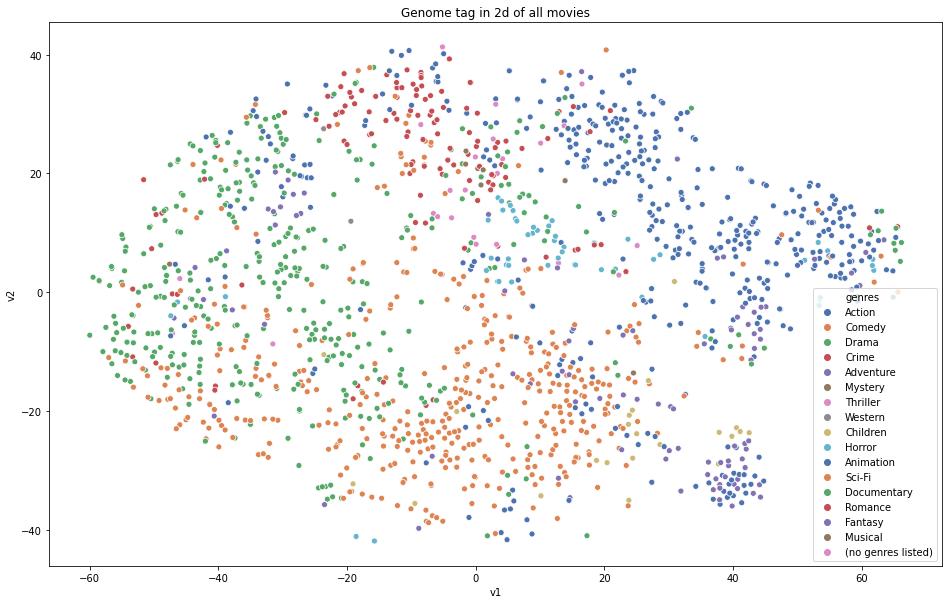

In [383]:
from sklearn.manifold import TSNE
#df_gescores_table is the df file from the csv
X_for_graph = df_tags.iloc[:,5:]
X_for_graph = TSNE(n_components = 2, random_state = 42).fit_transform(X_for_graph)

import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data):
    """Creates a dataframe from the given data, used for plotting"""
    df = pd.DataFrame(data)
    #df["sentiment"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df
plotting_data_embedded = creat_plotting_data(X_for_graph)
plotting_data_embedded['genres'] = df_tags['genres'].values
plotting_data_embedded['genres'] = plotting_data_embedded['genres'].map(lambda x: x[0])
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", data=plotting_data_embedded, hue="genres",palette="deep")
ax.set(title = 'Genome tag in 2d of all movies')
plt.show()

In [388]:
len(oscar_df[oscar_df['winner']==True]['film'].unique())

1274

In [20]:
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


In [195]:
genome_tag_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [22]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [28]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [139]:
movies = movies_df.join(movies_df.genres.str.get_dummies("|"))
movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
ratings_df['rating'].mean()

3.5304452124932677

In [275]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [274]:
viral_movies['rating_avg'] = viral_movies['rating_sum']/viral_movies['rating_count']
viral_movies.head(100)

,movieId,rating_count,rating_sum,title,genres,rating_avg
0,318,97999,433566.0,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188
1,356,97040,393651.0,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
2,296,92406,385700.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
3,593,87899,364905.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
4,2571,84545,350836.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
...,...,...,...,...,...,...
95,1073,33411,123683.5,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,3.701880
96,367,38699,123117.0,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,3.181400
97,8961,31857,122819.5,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,3.855338
98,5445,33163,121988.0,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller,3.678437


In [265]:
viral_movies = ratings_df[['movieId', 'rating','timestamp']].groupby(['movieId']).agg({'timestamp':'count', 'rating': 'sum'}).reset_index()
viral_movies.rename(columns={'timestamp': "rating_count",'rating': "rating_sum" }, inplace = True)
viral_movies = viral_movies.sort_values(by='rating_sum', ascending=False) 
viral_movies = viral_movies.merge(movies_df)
viral_movies['rating_avg'] = viral_movies['rating_avg']/viral_movies['rating_avg']

,movieId,rating_count,rating_sum,title,genres
0,318,97999,433566.0,"Shawshank Redemption, The (1994)",Crime|Drama
1,356,97040,393651.0,Forrest Gump (1994),Comedy|Drama|Romance|War
2,296,92406,385700.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,87899,364905.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,84545,350836.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller


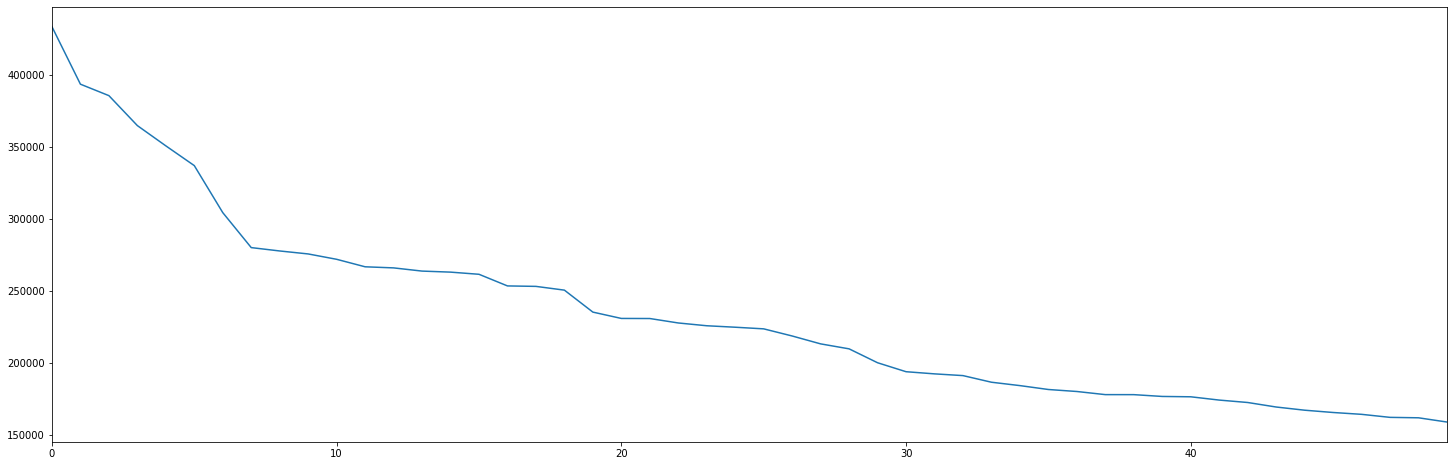

In [271]:
viral_movies['rating_sum'][:50].plot()

In [23]:
tags_df.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [34]:
userNum = len(ratings_df.userId.unique()) #283228 users
itemNum = len(ratings_df.movieId.unique()) #53889 items

print(userNum, itemNum)

283228 53889


In [36]:
df_item_summary = pd.DataFrame(ratings_df.groupby('movieId').size(), columns=['count'])
df_item_summary.describe()

df_item_summary = df_item_summary.sort_values(by='count', ascending=False) 
top_rated_movies = df_item_summary.nlargest(int(len(df_item_summary)*0.005), 'count') 
top_rated_movies.sum()/df_item_summary.sum()

count    0.317092
dtype: float64

In [37]:
top_rated_movies.head()

,count
movieId,
318,97999
356,97040
296,92406
593,87899
2571,84545


In [83]:
genome_scores_df['rank'] = genome_scores_df.groupby('movieId')['relevance'].rank(ascending=False, method='first')
genome_scores_df.sort_values(by='rank', ascending=True)

,movieId,tagId,relevance,rank
3931984,3888,905,0.98725,1.0
14816718,180095,439,0.81250,1.0
3249513,3197,874,0.99425,1.0
1094871,1068,712,0.99175,1.0
4687503,4619,664,0.96600,1.0
12163971,90647,748,0.99425,1.0
11515046,78003,423,0.99950,1.0
7892612,8795,1125,0.98850,1.0
5652028,5599,749,0.99825,1.0
7344180,7701,901,0.96025,1.0


In [87]:
df = genome_scores_df.groupby('rank')['relevance'].median()

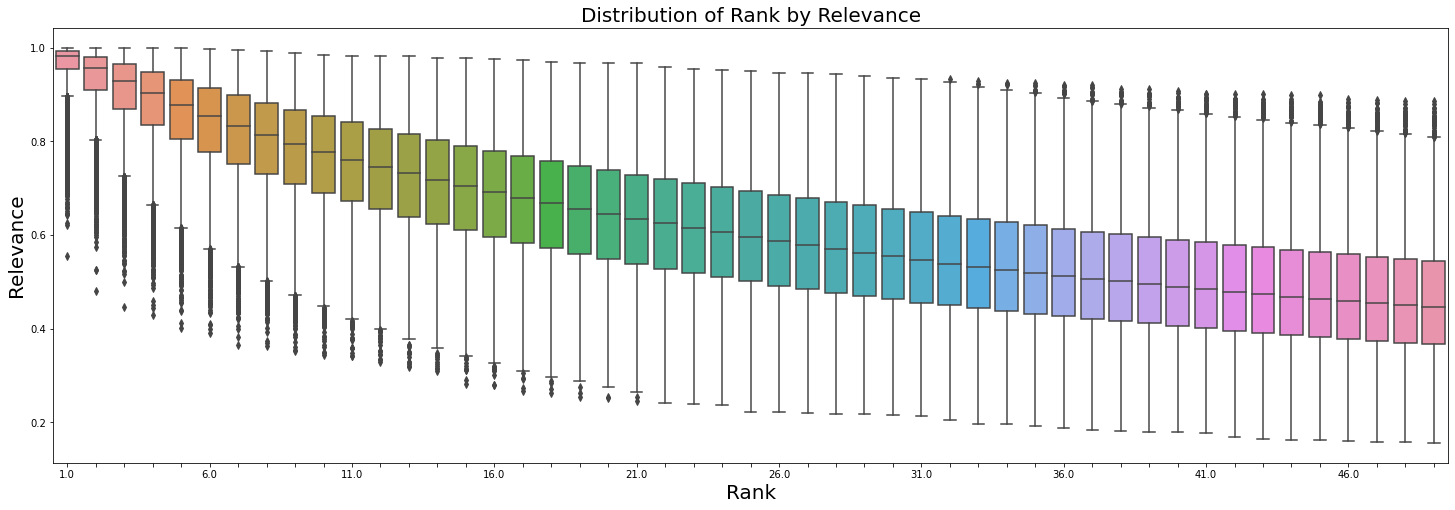

In [129]:
fig, ax = plt.subplots()

# figure size in inches
rcParams['figure.figsize'] = 25,8

genome_scores_df_top50 = genome_scores_df[genome_scores_df['rank'] < 50]
box_plot = sns.boxplot(x="rank", y="relevance", data=genome_scores_df_top50)

for ind, label in enumerate(box_plot.get_xticklabels()):
    if ind % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xlabel('Rank',fontsize=20);
ax.set_ylabel('Relevance',fontsize=20);
ax.set_title('Distribution of Rank by Relevance', fontsize=20)

plt.savefig('bar_chart.jpg', bbox_inches='tight', dpi=500)

plt.show()

In [121]:
from sklearn.metrics.pairwise import cosine_similarity
genome_scores_df_top50 = genome_scores_df_top50.merge(genome_tag_df)
genome_scores_df_top50 = genome_scores_df_top50.merge(movies_df)
df = genome_scores_df_top50.groupby('movieId')['tag'].apply(list).reset_index(name='tags')
df = df.merge(movies_df)
df['year'] = df['title'].map(lambda x: str(x)[-5:-1])
df['title'] = df['title'].map(lambda x: str(x)[:-7])
df.genres = df.genres.str.split('|')
df_tags = df.join(df.tags.str.get_dummies(","))
cos_sim = cosine_similarity(df_tags.iloc[:,5:])
toystory_top20 = np.argsort(cos_sim[0])[-20:][::-1]
df_tags[df_tags.index.isin(toystory_top20)]

,movieId,tags,title,genres,year,"""so bad it's funny""","""so bad it's good""","""so bad it's good""]","""writer's life""","""writer's life""]",...,['light',['long',['masterpiece',['mentor',['nostalgic',['original',['relationships',['runaway',['storytelling',['unlikely friendships'
0,1,"[action, adventure, animated, animation, carto...",Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2041,2294,"[adventure, animated, animation, cartoon, chil...",Antz,"[Adventure, Animation, Children, Comedy, Fantasy]",1998,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2097,2355,"[adventure, animated, animation, cartoon, chil...","Bug's Life, A","[Adventure, Animation, Children, Comedy]",1998,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2809,3114,"[adventure, animated, animation, cartoon, cgi,...",Toy Story 2,"[Adventure, Animation, Children, Comedy, Fantasy]",1999,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2954,3287,"[adventure, animated, animation, cartoon, chil...","Tigger Movie, The","[Animation, Children]",2000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4406,4886,"[animated, animation, cartoon, cgi, childhood,...","Monsters, Inc.","[Adventure, Animation, Children, Comedy, Fantasy]",2001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4692,5218,"[adventure, animated, animation, cartoon, cgi,...",Ice Age,"[Adventure, Animation, Children, Comedy]",2002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5611,6377,"[adventure, animated, animation, cartoon, chil...",Finding Nemo,"[Adventure, Animation, Children, Comedy]",2003,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7111,8961,"[action, adventure, animated, animation, carto...","Incredibles, The","[Action, Adventure, Animation, Children, Comedy]",2004,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8214,40339,"[animated, animation, cartoon, cgi, childhood,...",Chicken Little,"[Action, Adventure, Animation, Children, Comed...",2005,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
import sklearn.metrics.pairwise as pw
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances

In [123]:
df_tags.head()

,movieId,tags,title,genres,year,"""so bad it's funny""","""so bad it's good""","""so bad it's good""]","""writer's life""","""writer's life""]",...,['light',['long',['masterpiece',['mentor',['nostalgic',['original',['relationships',['runaway',['storytelling',['unlikely friendships'
0,1,"[action, adventure, animated, animation, carto...",Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,"[action, adventure, cgi, childhood, children, ...",Jumanji,"[Adventure, Children, Fantasy]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,"[dialogue, family, feel-good, friendship, fun ...",Grumpier Old Men,"[Comedy, Romance]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,"[dialogue, family, feel-good, friendship, good...",Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,"[cute, cute!, family, feel-good, fun, fun movi...",Father of the Bride Part II,[Comedy],1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
toystory_top20 = np.argsort(cos_sim[0])[-10:][::-1]
df_tags[df_tags.index.isin(toystory_top20)]

,movieId,tags,title,genres,year,"""so bad it's funny""","""so bad it's good""","""so bad it's good""]","""writer's life""","""writer's life""]",...,['light',['long',['masterpiece',['mentor',['nostalgic',['original',['relationships',['runaway',['storytelling',['unlikely friendships'
0,1,"[action, adventure, animated, animation, carto...",Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2097,2355,"[adventure, animated, animation, cartoon, chil...","Bug's Life, A","[Adventure, Animation, Children, Comedy]",1998,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2809,3114,"[adventure, animated, animation, cartoon, cgi,...",Toy Story 2,"[Adventure, Animation, Children, Comedy, Fantasy]",1999,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2954,3287,"[adventure, animated, animation, cartoon, chil...","Tigger Movie, The","[Animation, Children]",2000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4406,4886,"[animated, animation, cartoon, cgi, childhood,...","Monsters, Inc.","[Adventure, Animation, Children, Comedy, Fantasy]",2001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4692,5218,"[adventure, animated, animation, cartoon, cgi,...",Ice Age,"[Adventure, Animation, Children, Comedy]",2002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5611,6377,"[adventure, animated, animation, cartoon, chil...",Finding Nemo,"[Adventure, Animation, Children, Comedy]",2003,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8742,50872,"[animated, animation, cartoon, children, cleve...",Ratatouille,"[Animation, Children, Drama]",2007,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10235,78499,"[adventure, animated, animation, cartoon, cgi,...",Toy Story 3,"[Adventure, Animation, Children, Comedy, Fanta...",2010,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11421,103141,"[adventure, animated, animation, cartoon, chil...",Monsters University,"[Adventure, Animation, Comedy]",2013,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
toystory_top20

NameError: name 'toystory_top20' is not defined

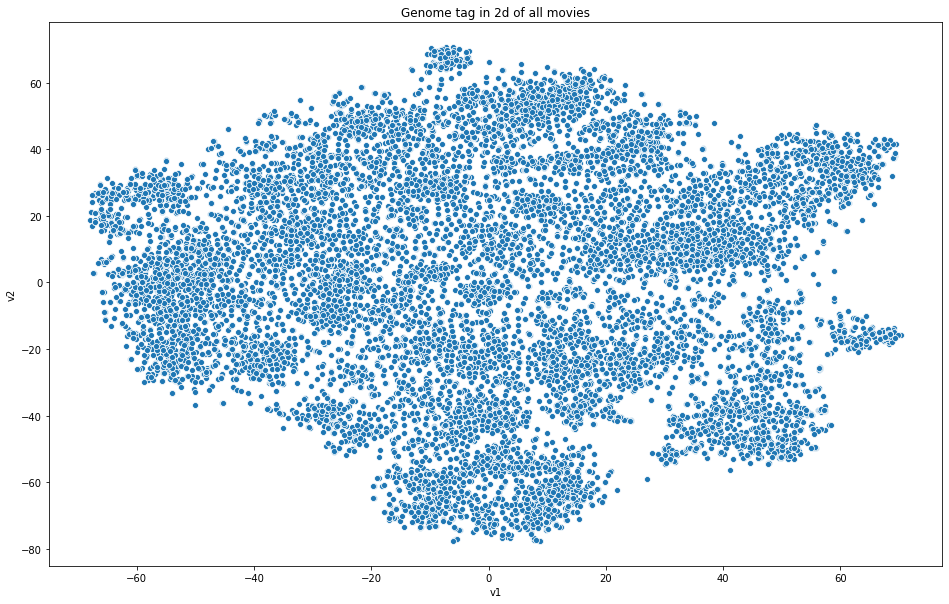

In [355]:
from sklearn.manifold import TSNE
#df_gescores_table is the df file from the csv
X_for_graph = df_tags.iloc[:,5:]
X_for_graph = TSNE(n_components = 2, random_state = 42).fit_transform(X_for_graph)
import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data):
    """Creates a dataframe from the given data, used for plotting"""
    df = pd.DataFrame(data)
    #df["sentiment"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df
plotting_data_embedded = creat_plotting_data(X_for_graph)
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", data=plotting_data_embedded)
ax.set(title = 'Genome tag in 2d of all movies')
plt.show()

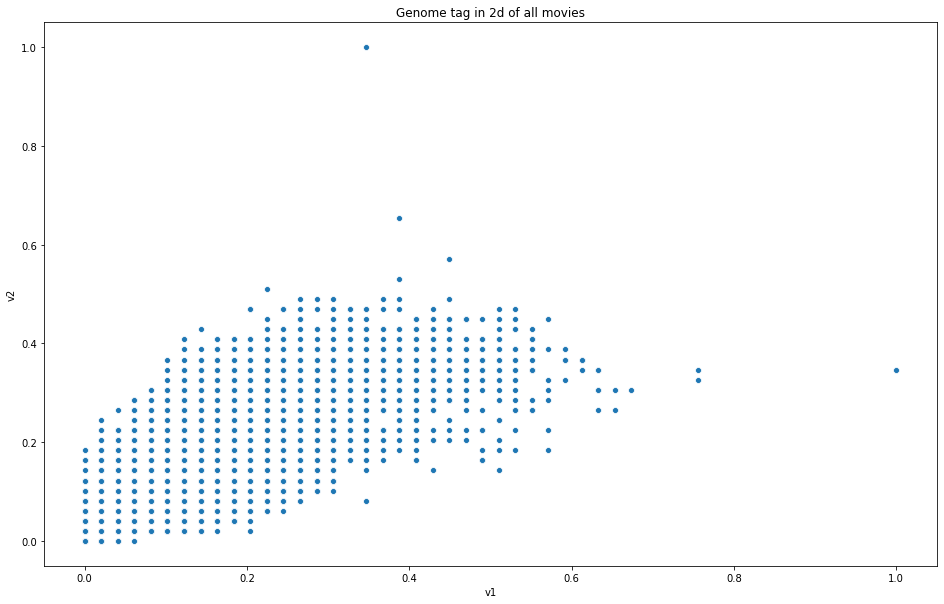

In [354]:
plotting_data_embedded = creat_plotting_data(cos_sim)
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", data=plotting_data_embedded)
ax.set(title = 'Genome tag in 2d of all movies')
plt.show()

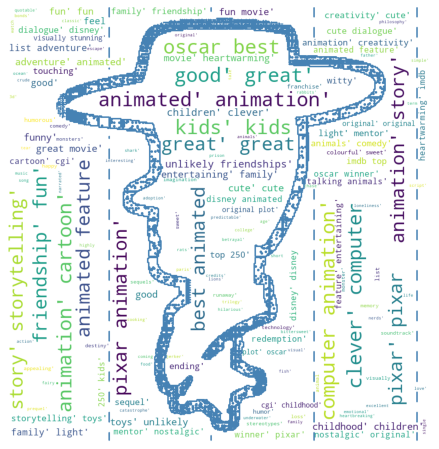

In [128]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS 

text = df_tags[df_tags.index.isin(toystory_top20)]['tags'].values 
woody_mask = np.array(Image.open(r"woody6.png"))
wordcloud = WordCloud(mask=woody_mask, background_color="white", contour_width=3, contour_color='steelblue').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('toy_story.jpg', bbox_inches='tight', dpi=500)


In [223]:
df_gescores_table.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,184987,184997,185029,185135,185425,185435,185585,186587,187593,187595
0,1,0.02900,0.03625,0.04150,0.03350,0.04050,0.02925,0.04775,0.03125,0.03225,...,0.01975,0.03450,0.04125,0.30750,0.03875,0.10625,0.04250,0.08950,0.05450,0.10150
1,2,0.02375,0.03625,0.04950,0.03675,0.05175,0.02575,0.05075,0.03750,0.03550,...,0.01650,0.02475,0.04100,0.37300,0.03175,0.10775,0.04175,0.09125,0.05250,0.10400
2,3,0.05425,0.08275,0.03000,0.04275,0.03600,0.02700,0.13400,0.08050,0.02150,...,0.13200,0.07375,0.08350,0.17900,0.06225,0.03025,0.06475,0.05075,0.07200,0.04950
3,4,0.06875,0.08175,0.09525,0.02625,0.04625,0.03450,0.08825,0.03150,0.01650,...,0.08500,0.19500,0.11925,0.15975,0.02650,0.05650,0.07625,0.04900,0.15050,0.07025
4,5,0.16000,0.10200,0.04525,0.05250,0.05500,0.06825,0.09550,0.05100,0.02350,...,0.09000,0.22150,0.21775,0.30775,0.06700,0.23175,0.08500,0.19475,0.23125,0.22875


In [217]:
df_gescores_table = pd.read_csv(r'gescores_table.csv')

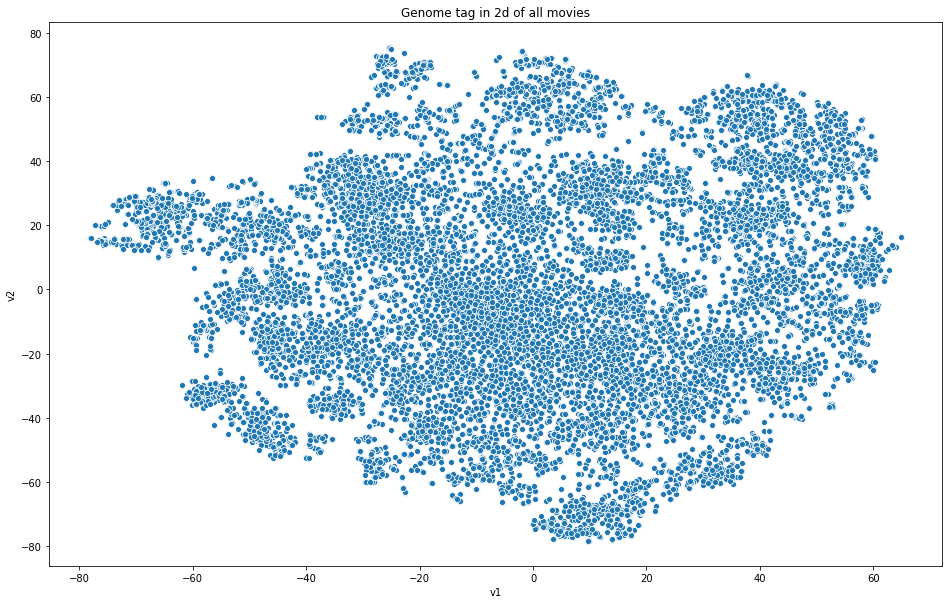

In [218]:
from sklearn.manifold import TSNE
#df_gescores_table is the df file from the csv
T = df_gescores_table.transpose()
X_for_graph = T
X_for_graph = TSNE(n_components = 2, random_state = 42).fit_transform(X_for_graph)
import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data):
    """Creates a dataframe from the given data, used for plotting"""
    df = pd.DataFrame(data)
    #df["sentiment"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df
plotting_data_embedded = creat_plotting_data(X_for_graph)
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", data=plotting_data_embedded)
ax.set(title = 'Genome tag in 2d of all movies')
plt.show()

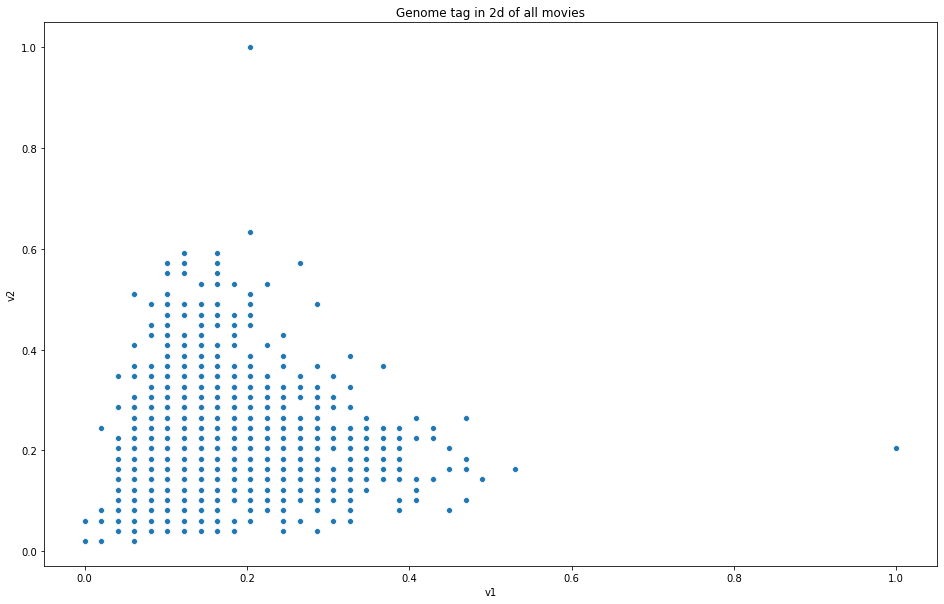